# CMRM Assignment No. 2

In [9]:
import os
import numpy as np
import soundfile as sf
import librosa
import sklearn # pip install sklearn
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm # pip install tqdm
from nmf import nmf

## Question 1

In [ ]:
## Define directories and lists based on provided code structure
output_dir = "audio/results"
source_dir = "audio/audio/sources"
target_dir = "audio/audio/targets"
sources = ["Bees_Buzzing.mp3", "Wind_Blowing.mp3", "Chainsaw_Sawing.mp3"]
targets = ["Jingle_Bells_Boogie.wav", "Have_Yourself.wav", "Blue_Christmas.wav", "White_Christmas.wav"]

# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)


# Define the source and target variables using the respective lists
source = sources[0]  # Selecting "Bees Buzzing.wav" from the sources list
target = targets[0]  # Selecting "Jingle Bells Boogie.wav" from the targets list


In [ ]:
## Load signals
Fs = 22050

# Load the source and target waveforms
source_path = os.path.join(source_dir, source)
target_path = os.path.join(target_dir, target)

# Load audio files
source_waveform, _ = librosa.load(source_path, sr=Fs)
target_waveform, _ = librosa.load(target_path, sr=Fs)



(0.046439909297052155, 4.445564516129032)

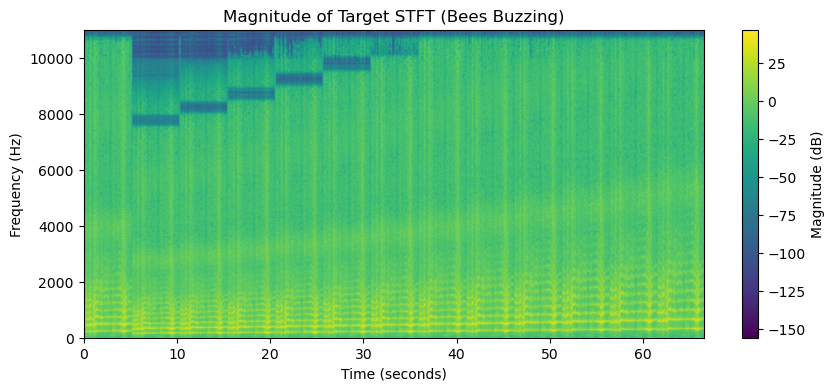

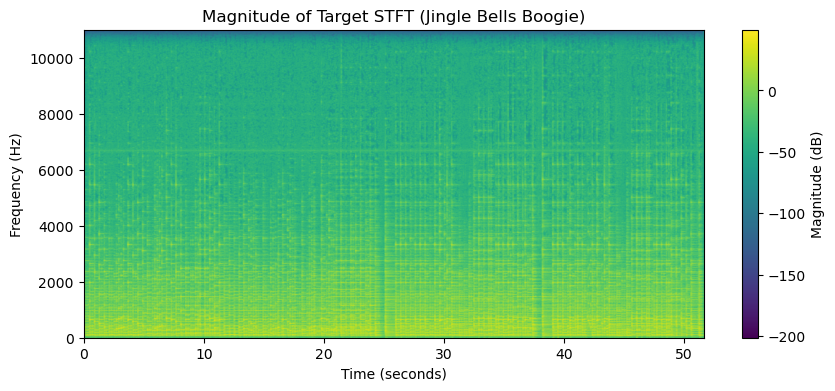

In [38]:
## Define sampling frequency and STFT parameters
N_length = 4960
H_size = 1024

## Compute the STFT of the source waveform
X_source = librosa.stft(source_waveform, n_fft=N_length, hop_length=H_size)

# Extract the magnitude of the source STFT
Y_source = np.abs(X_source)

eps= np.finfo(float).eps
Y_source_db = 20*np.log10(Y_source + eps)
#Y_source_db = np.log10(1 + 10* Y_source)

time_axis= np.arange(X_source.shape[1])/(Fs/H_size)
frequency_axis = np.arange(X_source.shape[0]) / (N_length / Fs)
    
x_ext = (time_axis[1] - time_axis[0]) / 2
y_ext = (frequency_axis[1] - frequency_axis[0]) / 2
image_extent = [time_axis[0]-x_ext, time_axis[-1]+x_ext, frequency_axis[0]-y_ext, frequency_axis[-1]-y_ext]
    
plt.figure(figsize=(10,4))
plt.title("Magnitude of Target STFT (Bees Buzzing)")
plt.imshow(Y_source_db, extent=image_extent, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')




# Compute the STFT of the target waveform
X_target = librosa.stft(target_waveform, n_fft=N_length, hop_length=H_size)
# Extract the magnitude of the target STFT

Y_target = np.abs(X_target)
Y_target_db = 20 * np.log10(Y_target + eps)

time_axis= np.arange(X_target.shape[1])/(Fs/H_size)
frequency_axis = np.arange(X_target.shape[0]) / (N_length / Fs)
    
x_ext = (time_axis[1] - time_axis[0]) / 2
y_ext = (frequency_axis[1] - frequency_axis[0]) / 2
image_extent = [time_axis[0]-x_ext, time_axis[-1]+x_ext, frequency_axis[0]-y_ext, frequency_axis[-1]-y_ext]
    
# Plot the magnitude of the target STFT    
plt.figure(figsize=(10,4))
plt.title("Magnitude of Target STFT (Jingle Bells Boogie)")
plt.imshow(Y_target_db, extent=image_extent, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')



# Compute time resolution and frequency resolution
time_res = H_size / Fs  # Time resolution in seconds
freq_res = Fs / N_length  # Frequency resolution in Hz


time_res, freq_res

## Source


## Plot

## Target

## Plot


## Question 2

In [ ]:
from nmf import nmf  # Funzione NMF dal file nmf.py

# 1. Inizializzazione della matrice di attivazione H0 con valori casuali
np.random.seed(42)  # Per riproducibilità
H0 = np.random.rand(Y_source.shape[1], Y_target.shape[1])  # Dimensioni temporali di X_source e X_target

# 2. Inizializzazione della matrice template W0 normalizzata
eps = np.finfo(float).eps
W0 = Y_source / (np.sum(Y_source, axis=0, keepdims=True) + eps)  # Divisione Hadamard (element-wise)

# 3. Definizione di Xs (normalizzazione della STFT sorgente)
Xs = X_source / (np.sum(Y_source, axis=0, keepdims=True) + eps)  # Divisione Hadamard

# 4. Esecuzione della NMF utilizzando la funzione fornita
W, H = nmf(
    V=Y_target,
    init_W=W0,
    init_H=H0,
    num_iter=50,
    fix_W=True,
    cont_polyphony=10,
    cont_length=7,
    cont_grid=5,
    cont_sparsen=(1, 7)
)

# 5. Calcolo dell'approssimazione e dell'errore
V_approx = np.dot(W, H)
error = np.linalg.norm(Y_target - V_approx, ord='fro')
print(f"Norma-2 dell'errore tra Y_target e V_approx: {error:.4f}")

# 6. Plot della matrice di attivazione (H0 e H)
plt.figure(figsize=(16, 8))

# Matrice H0 (iniziale)
plt.subplot(2, 2, 1)
plt.title("Matrice H0 (Iniziale)")
plt.imshow(H0, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="Valore")
plt.xlabel("Frame temporale (Target)")
plt.ylabel("Template spettrale (Source)")

# Matrice H (appresa)
plt.subplot(2, 2, 2)
plt.title("Matrice H (Appresa)")
plt.imshow(H, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="Valore")
plt.xlabel("Frame temporale (Target)")
plt.ylabel("Template spettrale (Source)")

# Magnitudine originale del target
plt.subplot(2, 2, 3)
plt.title("Magnitudine originale del target (Y_target)")
plt.imshow(20 * np.log10(Y_target + eps), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Magnitudine (dB)")
plt.xlabel("Frame temporale")
plt.ylabel("Frequenza (Hz)")

# Magnitudine approssimata
plt.subplot(2, 2, 4)
plt.title("Magnitudine approssimata (V_approx)")
plt.imshow(20 * np.log10(V_approx + eps), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Magnitudine (dB)")
plt.xlabel("Frame temporale")
plt.ylabel("Frequenza (Hz)")

plt.tight_layout()
plt.show()

#7. Funzione per visualizzazione compressa di H, W, V_approx, e Y_target
def visualize_nmf(Y_target, H, W, V_approx, gamma=0.5, freq_limit=2000):
    """
    Visualizza la matrice di attivazione, i template spettrali, la magnitudine approssimata
    e la magnitudine originale in versione compressa.

    Args:
        Y_target (np.ndarray): Magnitudine STFT del target
        H (np.ndarray): Matrice di attivazione
        W (np.ndarray): Matrice dei template spettrali
        V_approx (np.ndarray): Magnitudine approssimata tramite NMF
        gamma (float): Fattore di compressione
        freq_limit (int): Limite massimo della frequenza sull'asse y (Hz)
    """
    # Calcolo del numero di bin di frequenza sotto il limite imposto
    freq_bins = int(freq_limit / (Fs / N_length))  # Limita l'asse y a 2000 Hz

    plt.figure(figsize=(16, 10))

    # 1. Matrice H compressa
    plt.subplot(2, 2, 1)
    plt.title("Matrice H (Compressa)")
    plt.imshow(H ** gamma, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label="Valore compresso")
    plt.xlabel("Frame temporale")
    plt.ylabel("Template spettrale")

    # 2. Matrice W compressa
    plt.subplot(2, 2, 2)
    plt.title("Matrice W (Compressa)")
    plt.imshow(W[:freq_bins, :] ** gamma, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label="Valore compresso")
    plt.xlabel("Template spettrale")
    plt.ylabel("Frequenza (Hz)")
    plt.ylim([0, freq_bins])

    # 3. Magnitudine approssimata compressa
    plt.subplot(2, 2, 3)
    plt.title("Magnitudine approssimata (Compressa)")
    plt.imshow(20 * np.log10(V_approx[:freq_bins, :] + eps), aspect='auto', origin='lower', cmap='inferno')
    plt.colorbar(label="Magnitudine (dB)")
    plt.xlabel("Frame temporale")
    plt.ylabel("Frequenza (Hz)")
    plt.ylim([0, freq_bins])

    # 4. Magnitudine originale compressa
    plt.subplot(2, 2, 4)
    plt.title("Magnitudine originale (Compressa)")
    plt.imshow(20 * np.log10(Y_target[:freq_bins, :] + eps), aspect='auto', origin='lower', cmap='inferno')
    plt.colorbar(label="Magnitudine (dB)")
    plt.xlabel("Frame temporale")
    plt.ylabel("Frequenza (Hz)")
    plt.ylim([0, freq_bins])

    plt.tight_layout()
    plt.show()

# Chiamata della funzione di visualizzazione
visualize_nmf(Y_target, H, W, V_approx, gamma=0.5, freq_limit=2000)



## Initialize activations randomly
# Initialize activation matrix H0

## Initialize templates according to source frames


# NMF


# Error norm



66.54839002267573
51.68761904761905


In [ ]:
# Plot H0 and H


In [ ]:
# Define a function to visualize the NMF components
def visualize_nmf(V, W, H, fs, time_res, gamma=2):
    """Visualize the matrices W, H, and compare reconstruction V ~ WH to V

    Args:
        V: target
        W: template matrix
        H: activation matrix
        fs: sampling frequency
        time_res: time resolution
        gamma: compression factor for V

    Returns:
        None
    """
    
    

In [ ]:
# Test visualize_nmf


## Question 3

In [ ]:
# Replace the magnitude frames by complex valued frames


# Re-synthesize using ISTFT


# Re-synthesize using Griffin-Lim algorithm



In [ ]:
# Save result


In [ ]:
# Phase check 
# ISTFT


# Griffin-Lim


In [ ]:
# Play target


In [ ]:
# Play source


In [ ]:
# Play new target - ISTFT


In [ ]:
# Play new target - GF


## Question 4

In [ ]:
# Define the function timbre_transfer
def timbre_transfer(t, s, fs, hop_size=1024, win_length=4096, resynth='gf', plot=False):
    """Transfer the timbre from the source to the target

    Args:
        t: target waveform
        s: source waveform
        fs: sampling frequency
        hop_size: hop size used for the STFT computation and the re-synthesis
        win_length: length of the window used for the STFT computation and the re-synthesis
        resynth: method used for the audio re-synthesis. Methods available: 'gf' = Griffin-Lim, 'istft' = Inverse STFT
        plot: boolean enabling visualization of NMF matrices and target spectrogram 

    Returns:
        y: audio waveform resynthesized through the chosen method
    """
    
    return y

## Question 5

In [ ]:
# Use the function timbre_tansfer for all the possible combinations of source and target

